In [8]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed
from tqdm import tqdm
import mlflow
import mlflow.pytorch

import torch 
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

torch.manual_seed(42)

# Connect to MLflow

In [2]:
# your MLflow server address on LiSC
# you can verify on the login node with: echo "Your MLflow server is running at: http://$(hostname -I | awk '{print $1}'):PORT"
MLFLOW_TRACKING_URI = "http://10.65.0.202:8888"

# connect to MLflow
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

# experiment Name (Project)
EXPERIMENT_NAME = "Predict Genes From Community"

# create the experiment if it doesn't exist
if mlflow.get_experiment_by_name(EXPERIMENT_NAME) is None:
    mlflow.create_experiment(EXPERIMENT_NAME)

# set the experiment
mlflow.set_experiment(EXPERIMENT_NAME)

print(f"Connected to MLflow at: {MLFLOW_TRACKING_URI}")

Connected to MLflow at: http://10.65.0.202:8888


# Load Data

In [3]:
# import data
df_species = pd.read_parquet('../processed_data/species_coverage.parquet')

df_genes   = pd.read_parquet('../processed_data/gene_coverage.parquet')
df_genes = df_genes.set_index("Sample")

# match indexes
df_species = df_species.reindex(df_genes.index)

# Data Processing

In [4]:
count_species = (df_species > 0).sum(0)
count_genes = (df_genes > 0).sum(0)

# remove columns that rarely show up
threshold = 200

species_keep = count_species[count_species >= threshold].index
genes_keep = count_genes[count_genes >= threshold].index

df_species = df_species[species_keep]
df_genes = df_genes[genes_keep]

del species_keep
del genes_keep

# Logistic Regression

In [5]:
# convert genes to binary for logistic regression
df_genes_binary = (df_genes > 0).astype(int)

del df_genes

In [6]:
# for future reference
species_names = df_species.columns.tolist()
gene_names = df_genes_binary.columns.tolist()

#  -- tensors --
X = torch.tensor(df_species.values, dtype=torch.float32)  # Species as input
y = torch.tensor(df_genes_binary.values, dtype=torch.float32)  # Genes as output

# train val test split
total_samples = X.shape[0]
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size  # Ensures all samples are used

indices = torch.randperm(total_samples)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

# -- datasets and loaders --
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# If GPU is available, use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)

    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [14]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, learning_rate=0.01, epochs=5, 
                 transform=None, run_name="Default Run", description="No description"):
        """
        Trainer class for model training and MLflow logging.
        
        :param model: PyTorch model
        :param train_loader: DataLoader for training data
        :param val_loader: DataLoader for validation data
        :param learning_rate: Learning rate for optimizer
        :param epochs: Number of training epochs
        :param transform: PyTorch transformation function (e.g., torch.log, torch.sqrt) - only applied to X
        :param run_name: Name of the MLflow run
        :param description: Description for the MLflow run
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.epochs = epochs
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.transform = transform  # PyTorch function for data transformation
        self.run_name = run_name
        self.description = description
        self.train_losses = []
        self.val_losses = []
        self.run_id = None  # Store the MLflow run ID here

    def preprocess(self, X):
        """Apply the transformation function ONLY to X, not y."""
        return self.transform(X) if self.transform else X

    def train(self):
        """Run the training loop with MLflow logging."""
        # Start a new MLflow run and store the run_id
        with mlflow.start_run(run_name=self.run_name) as run:
            self.run_id = run.info.run_id  # Store the run ID
            mlflow.set_tag("Description", self.description)  # Log the description
            mlflow.log_param("learning_rate", self.optimizer.param_groups[0]['lr'])
            mlflow.log_param("epochs", self.epochs)
            mlflow.log_param("data_transformation", self.transform.__name__ if self.transform else "None")

            for epoch in range(self.epochs):
                self.model.train()
                train_loss = 0

                for batch_X, batch_y in self.train_loader:
                    batch_X, batch_y = self.preprocess(batch_X.to(device)), batch_y.to(device)  # Transform only X
                    self.optimizer.zero_grad()
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs, batch_y)
                    loss.backward()
                    self.optimizer.step()
                    train_loss += loss.item()

                train_loss /= len(self.train_loader)
                self.train_losses.append(train_loss)

                # Validation
                self.model.eval()
                val_loss = 0
                with torch.no_grad():
                    for batch_X, batch_y in self.val_loader:
                        batch_X, batch_y = self.preprocess(batch_X.to(device)), batch_y.to(device)  # Transform only X
                        outputs = self.model(batch_X)
                        loss = self.criterion(outputs, batch_y)
                        val_loss += loss.item()

                val_loss /= len(self.val_loader)
                self.val_losses.append(val_loss)

                # Log metrics to MLflow
                mlflow.log_metric("train_loss", train_loss, step=epoch)
                mlflow.log_metric("val_loss", val_loss, step=epoch)

                print(f"Epoch [{epoch+1}/{self.epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

            # Log the model to MLflow
            input_example = torch.rand(1, batch_X.shape[1]).to(device).cpu().numpy()  # Convert to numpy
            output_example = self.model(torch.tensor(input_example, dtype=torch.float32, device=device)).cpu().detach().numpy()  # Convert output to numpy
            signature = mlflow.models.infer_signature(input_example, output_example)
            
            mlflow.pytorch.log_model(self.model, "model", input_example=input_example, signature=signature)

            print(f"✅ Training Completed & Logged to MLflow: {self.run_name}")
            print(f"🏃 View run {self.run_name} at: {mlflow.get_tracking_uri()}")

## Experiments

In [17]:
input_size = X.shape[1]  # Number of species
output_size = y.shape[1] # Number of genes

# Create fresh models for each run
model1 = LogisticRegressionModel(input_size, output_size).to(device)
model2 = LogisticRegressionModel(input_size, output_size).to(device)

# Run 1: No Transformation
trainer_no_transform = Trainer(
    model1, train_loader, val_loader, 
    learning_rate=0.01, epochs=4, 
    transform=None,  # No transformation
    run_name="Baseline Model",
    description="Training with raw data (no transformation)"
)
trainer_no_transform.train()

# Run 2: With Log Transformation
trainer_log_transform = Trainer(
    model2, train_loader, val_loader, 
    learning_rate=0.01, epochs=4, 
    transform=torch.log1p, 
    run_name="Log(x) Transform Model",
    description="Training with log(X) transformation"
)
trainer_log_transform.train()

Epoch [1/4], Train Loss: 6.2830, Val Loss: 3.7317
Epoch [2/4], Train Loss: 3.4637, Val Loss: 3.4959
Epoch [3/4], Train Loss: 3.2389, Val Loss: 3.4454
Epoch [4/4], Train Loss: 3.2615, Val Loss: 3.3691
✅ Training Completed & Logged to MLflow: Baseline Model
🏃 View run Baseline Model at: http://10.65.0.202:8888
🏃 View run Baseline Model at: http://10.65.0.202:8888/#/experiments/3/runs/3ba0b28e49564a69b8cb84e162e6ce71
🧪 View experiment at: http://10.65.0.202:8888/#/experiments/3
Epoch [1/4], Train Loss: 0.5136, Val Loss: 0.4795
Epoch [2/4], Train Loss: 0.4550, Val Loss: 0.4627
Epoch [3/4], Train Loss: 0.4412, Val Loss: 0.4585
Epoch [4/4], Train Loss: 0.4360, Val Loss: 0.4526
✅ Training Completed & Logged to MLflow: Log Transformed Model
🏃 View run Log Transformed Model at: http://10.65.0.202:8888
🏃 View run Log Transformed Model at: http://10.65.0.202:8888/#/experiments/3/runs/d1b59ab3dde74e52acd4937ec7a48311
🧪 View experiment at: http://10.65.0.202:8888/#/experiments/3


# Model Evaluation

In [21]:
def evaluate_and_log(trainer, test_loader):
    """Evaluates a model and logs metrics + artifacts to MLflow."""
    print(f"🔎 Evaluating {trainer.run_name}...")

    trainer.model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # Apply transformation ONLY to X (if defined in trainer)
            batch_X = trainer.preprocess(batch_X)

            outputs = trainer.model(batch_X)
            all_preds.append(outputs)
            all_labels.append(batch_y)

    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    # Convert tensors to numpy arrays
    all_preds_np = all_preds.cpu().numpy()
    all_labels_np = all_labels.cpu().numpy()

    # Apply threshold of 0.5 to get binary predictions
    predictions = (all_preds_np >= 0.5).astype(int)

    # Compute metrics for each output
    num_outputs = predictions.shape[1]

    # Compute metrics (sequentially)
    results = []
    print(f"📊 Computing metrics for {trainer.run_name}...")
    for i in range(num_outputs):
        results.append(compute_metrics(i, all_labels_np, predictions, all_preds_np))

    accuracies, precisions, recalls, f1s, roc_aucs = map(list, zip(*results))

    # Use the existing run_id to log metrics
    if trainer.run_id:
        with mlflow.start_run(run_id=trainer.run_id):
            mlflow.log_metric("accuracy_mean", np.mean(accuracies))
            mlflow.log_metric("precision_mean", np.mean(precisions))
            mlflow.log_metric("recall_mean", np.mean(recalls))
            mlflow.log_metric("f1_mean", np.mean(f1s))
            mlflow.log_metric("roc_auc_mean", np.nanmean(roc_aucs))  # Ignore NaN values
    else:
        print(f"⚠️ No run ID found for {trainer.run_name}. Metrics not logged.")

    print(f"✅ Evaluation for {trainer.run_name} completed!")
    return accuracies, precisions, recalls, f1s, roc_aucs

🔎 Evaluating Baseline Model...
📊 Computing metrics for Baseline Model...
🏃 View run Baseline Model at: http://10.65.0.202:8888/#/experiments/3/runs/21eaf35c091e45eeb3f66130f2fdba4c
🧪 View experiment at: http://10.65.0.202:8888/#/experiments/3
✅ Evaluation for Baseline Model completed!
🔎 Evaluating Log Transformed Model...
📊 Computing metrics for Log Transformed Model...
🏃 View run Log Transformed Model at: http://10.65.0.202:8888/#/experiments/3/runs/4b5b4d7f3cbb4b0b89463fc293880fb1
🧪 View experiment at: http://10.65.0.202:8888/#/experiments/3
✅ Evaluation for Log Transformed Model completed!


## Comparisson plot

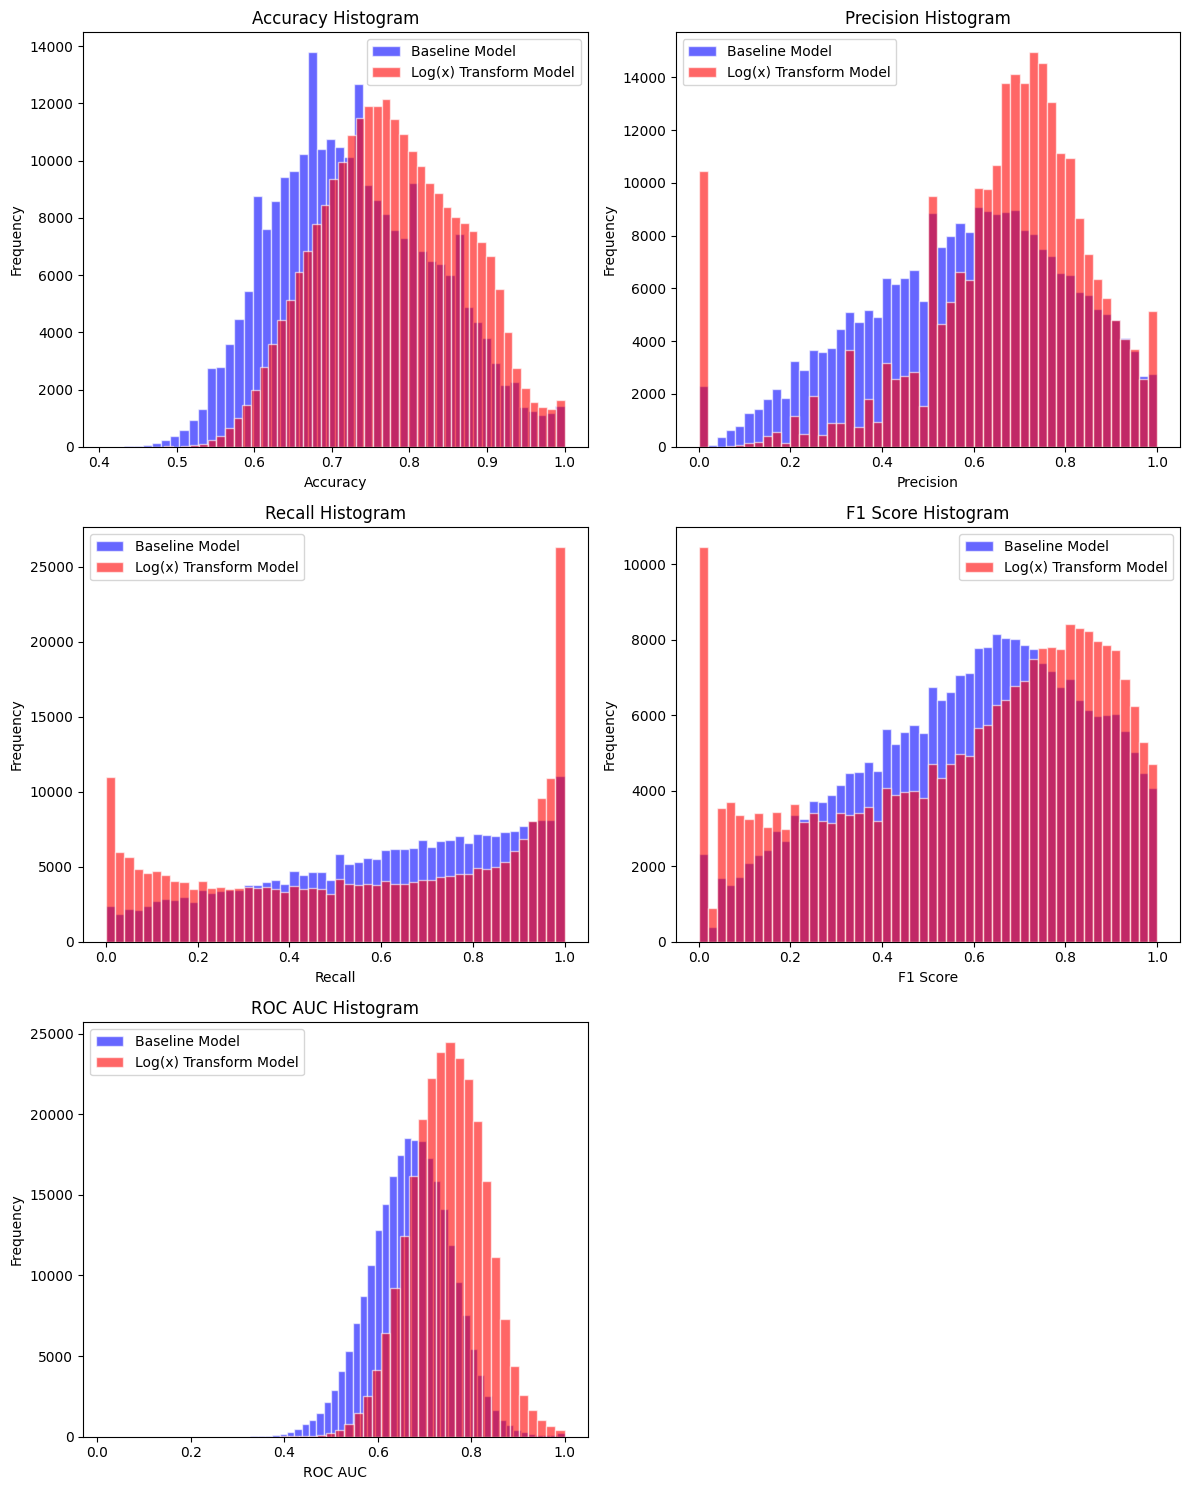

In [23]:
fig, axs = plt.subplots(3, 2, figsize=(12, 15))

bins = 50

# Define colors for each model
baseline_color = "blue"
log_transform_color = "red"

# Accuracy Histogram
axs[0, 0].hist(metrics_no_transform[0], bins=bins, alpha=0.6, color=baseline_color, edgecolor='white', label="Baseline Model")
axs[0, 0].hist(metrics_log_transform[0], bins=bins, alpha=0.6, color=log_transform_color, edgecolor='white', label="Log(x) Transform Model")
axs[0, 0].set_title('Accuracy Histogram')
axs[0, 0].set_xlabel('Accuracy')
axs[0, 0].set_ylabel('Frequency')
axs[0, 0].legend()

# Precision Histogram
axs[0, 1].hist(metrics_no_transform[1], bins=bins, alpha=0.6, color=baseline_color, edgecolor='white', label="Baseline Model")
axs[0, 1].hist(metrics_log_transform[1], bins=bins, alpha=0.6, color=log_transform_color, edgecolor='white', label="Log(x) Transform Model")
axs[0, 1].set_title('Precision Histogram')
axs[0, 1].set_xlabel('Precision')
axs[0, 1].set_ylabel('Frequency')
axs[0, 1].legend()

# Recall Histogram
axs[1, 0].hist(metrics_no_transform[2], bins=bins, alpha=0.6, color=baseline_color, edgecolor='white', label="Baseline Model")
axs[1, 0].hist(metrics_log_transform[2], bins=bins, alpha=0.6, color=log_transform_color, edgecolor='white', label="Log(x) Transform Model")
axs[1, 0].set_title('Recall Histogram')
axs[1, 0].set_xlabel('Recall')
axs[1, 0].set_ylabel('Frequency')
axs[1, 0].legend()

# F1 Score Histogram
axs[1, 1].hist(metrics_no_transform[3], bins=bins, alpha=0.6, color=baseline_color, edgecolor='white', label="Baseline Model")
axs[1, 1].hist(metrics_log_transform[3], bins=bins, alpha=0.6, color=log_transform_color, edgecolor='white', label="Log(x) Transform Model")
axs[1, 1].set_title('F1 Score Histogram')
axs[1, 1].set_xlabel('F1 Score')
axs[1, 1].set_ylabel('Frequency')
axs[1, 1].legend()

# ROC AUC Histogram
axs[2, 0].hist(metrics_no_transform[4], bins=bins, alpha=0.6, color=baseline_color, edgecolor='white', label="Baseline Model")
axs[2, 0].hist(metrics_log_transform[4], bins=bins, alpha=0.6, color=log_transform_color, edgecolor='white', label="Log(x) Transform Model")
axs[2, 0].set_title('ROC AUC Histogram')
axs[2, 0].set_xlabel('ROC AUC')
axs[2, 0].set_ylabel('Frequency')
axs[2, 0].legend()

# Empty subplot (to keep layout balanced)
axs[2, 1].axis('off')

plt.tight_layout()
plt.show()
